## Querying Document

In [1]:
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from dotenv import load_dotenv
import os

In [5]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPEN_AI_KEY"] = api_key

In [7]:
Settings.llm = OpenAI(temperature=0.2, model="gpt-3.5-turbo")

In [3]:
documents = SimpleDirectoryReader("data").load_data()
index = VectorStoreIndex.from_documents(
    documents,
)

In [4]:
print(f"Number of documents:{len(documents)}")

Number of documents:51


In [5]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10
)

In [6]:
response_synthesizer = get_response_synthesizer(response_mode=ResponseMode.COMPACT)

In [7]:
query_engine = RetrieverQueryEngine(
    retriever = retriever,
    node_postprocessors = [SimilarityPostprocessor(similarity_cutoff=0.7,
                                                    filter_empty = True,
                                                    filter_duplicates = True,
                                                    filter_similar = True,)]
)

In [8]:
response = query_engine.query("What are the potential benifits of social media use among children and adolescents?")
print(response)

Social media can provide benefits for some youth by offering positive community and connection with others who share identities, abilities, and interests. It can provide access to important information, create a space for self-expression, help in forming and maintaining friendships online, and develop social connections. These relationships can offer opportunities for positive interactions with diverse peer groups, provide important social support, and may support mental health and well-being, especially for marginalized youth.


## Prompt Formatting

### Partial Formatting

In [2]:
from llama_index.core import PromptTemplate

In [9]:
qa_prompt_templ_str = """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Please write the answer in the style of {tone_name}
Query: {query_str}
Answer: \
"""

In [12]:
prompt_tmpl = PromptTemplate(qa_prompt_templ_str)
partial_prompt_templ = prompt_tmpl.partial_format(tone_name="Shakespeare")

In [13]:
fmt_prompt = partial_prompt_templ.format(
    context_str = "In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters",
    query_str="How many params does llama 2 have",
)
print(fmt_prompt)

Context information is below.
---------------------
In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters
---------------------
Given the context information and not prior knowledge, answer the query.
Please write the answer in the style of Shakespeare
Query: How many params does llama 2 have
Answer: 


### Variable Mapping

In [14]:
my_context=""
my_query=""

In [15]:
qa_prompt_templ_str = """\
Context information is below.
---------------------
{my_context}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {my_query}
Answer: \
"""

In [18]:
template_var_mappings = {"context_str":"my_context", "query_str":"my_query"}

In [19]:
prompt_tmpl = PromptTemplate(
    qa_prompt_templ_str, template_var_mappings= template_var_mappings
)

In [20]:
fmt_prompt = partial_prompt_templ.format(
    context_str = "In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters",
    query_str="How many params does llama 2 have",
)
print(fmt_prompt)

Context information is below.
---------------------
In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters
---------------------
Given the context information and not prior knowledge, answer the query.
Please write the answer in the style of Shakespeare
Query: How many params does llama 2 have
Answer: 


### Function Call

In [29]:
qa_prompt_templ_str = """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: \
"""

In [30]:
def format_context_fn(**kwargs):
    context_list = kwargs["context_str"].split("\n\n")
    fmtted_context = "\n\n".join([f"- {c}" for c in context_list])
    return fmtted_context

In [31]:
prompt_tmpl = PromptTemplate(
    qa_prompt_templ_str, function_mappings={"context_str":format_context_fn}
)

In [32]:
context_str="""\
In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters.

Our fine-tuned LLMs, called Llama 2-Chat, are optimized for dialogue use cases.

Our models outperform open-source chat models on most benchmarks we tested, and based on our human evaluations for helpfulness and safety, may be a suitable substitute for closed-source models.
"""

In [33]:
fmt_prompt2 = prompt_tmpl.format(
    context_str=context_str, query_str="How many params does llama 2 have"
)

print(fmt_prompt2)

Context information is below.
---------------------
- In this work, we develop and release Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters.

- Our fine-tuned LLMs, called Llama 2-Chat, are optimized for dialogue use cases.

- Our models outperform open-source chat models on most benchmarks we tested, and based on our human evaluations for helpfulness and safety, may be a suitable substitute for closed-source models.

---------------------
Given the context information and not prior knowledge, answer the query.
Query: How many params does llama 2 have
Answer: 


### Conversational Prompts

In [35]:
from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI

In [37]:
messages = [
    ChatMessage(
        role="system",
        content="""You are a Physics teacher who teaches 12 year old students. you have a good sense of humour. You are about to teach about the solar system."""
    ),
    ChatMessage(role="user", content="What are you going to teach today?")
]
resp = OpenAI().chat(messages)
print(resp)

assistant: Today, we're going to embark on a journey through space and explore the wonders of our solar system! Get ready to learn about the planets, moons, and all the cosmic awesomeness that surrounds us. It's going to be out of this world! 🌌🚀


## Semantic Similarity Evaluator

In [44]:
from llama_index.core.evaluation import SemanticSimilarityEvaluator

In [45]:
evaluator = SemanticSimilarityEvaluator()

In [46]:
def evaluate_similarity():
    response = """Seventeen is considered a "self-producing" idol group, with the members involved in songwriting, music production, and choreographing, among other aspects of their music and performances. They perform as one group and are divided into three units—hip-hop, vocal, and performance—each with a different area of specialization. They have been labeled "Performance Kings", "Theater Kids of K-Pop", and "K-Pop Performance Powerhouse'" by various domestic and international media outlets. """
    reference = """The name Seventeen is derived from the expression "13 members + 3 teams + 1 group", representing how the 13 members are divided into three different teams and come together to form one cohesive group."""
    result = evaluator.evaluate(
        response=response,
        reference=reference,
    )
    
    print("Score: ", result.score)
    print("Passing: ", result.passing)

In [47]:
def main():
    evaluate_similarity()

In [48]:
if __name__ == "__main__":
    main()

RuntimeError: Detected nested async. Please use nest_asyncio.apply() to allow nested event loops.Or, use async entry methods like `aquery()`, `aretriever`, `achat`, etc.

## Query Pipelines

### Sequential Query Pipeline

In [49]:
from llama_index.core.query_pipeline import QueryPipeline

In [50]:
prompt_str = "please give me the name, cast and year of release for movies similar to the movie {movie_name}"
prompt_template = PromptTemplate(prompt_str)
llm = OpenAI(model="gpt-3.5-turbo")

In [53]:
p = QueryPipeline(chain=[prompt_template, llm], verbose=True)

In [54]:
response = p.run(movie_name="Big Hero 6")
print(response)

> Running module 1d627550-48a2-4eae-9231-9d8acd27cd92 with input: 
movie_name: Big Hero 6

> Running module fb4ebfeb-ce85-4b19-9b62-d7d07bf4d944 with input: 
messages: please give me the name, cast and year of release for movies similar to the movie Big Hero 6

assistant: 1. "The Incredibles" (2004) 
   - Cast: Craig T. Nelson, Holly Hunter, Samuel L. Jackson
   - Year of Release: 2004

2. "Wreck-It Ralph" (2012)
   - Cast: John C. Reilly, Sarah Silverman, Jack McBrayer
   - Year of Release: 2012

3. "Zootopia" (2016)
   - Cast: Ginnifer Goodwin, Jason Bateman, Idris Elba
   - Year of Release: 2016

4. "Moana" (2016)
   - Cast: Auli'i Cravalho, Dwayne Johnson, Rachel House
   - Year of Release: 2016

5. "Ralph Breaks the Internet" (2018)
   - Cast: John C. Reilly, Sarah Silverman, Gal Gadot
   - Year of Release: 2018


### DAG Pipeline

In [56]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.response_synthesizers import TreeSummarize
from llama_index.core import VectorStoreIndex

In [60]:
load_dotenv()

True

In [57]:
prompt_str = "What are the potential risks of harm from {topic}"
prompt_tmpl = PromptTemplate(prompt_str)

In [61]:
retriever = index.as_retriever(similarity_top_k=5)
reranker = CohereRerank()
summarizer = TreeSummarize(llm=llm)
p = QueryPipeline(verbose=True)

In [62]:
p.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever,
        "summarizer": summarizer,
        "reranker": reranker
    }
)

In [63]:
p.add_link("prompt_tmpl", "llm")
p.add_link("llm","retriever")
p.add_link("retriever", "reranker", dest_key="nodes")
p.add_link("llm", "reranker", dest_key="query_str")
p.add_link("reranker", "summarizer", dest_key="nodes")
p.add_link("llm", "summarizer", dest_key="query_str")

In [64]:
output=p.run(topic="Content Exposure")
print(output)

> Running module prompt_tmpl with input: 
topic: Content Exposure

> Running module llm with input: 
messages: What are the potential risks of harm from Content Exposure

> Running module retriever with input: 
input: assistant: 1. Exposure to inappropriate or harmful content: Users may come across content that is violent, sexually explicit, or promotes harmful behaviors such as self-harm or substance abuse.

2. Ps...

> Running module reranker with input: 
query_str: assistant: 1. Exposure to inappropriate or harmful content: Users may come across content that is violent, sexually explicit, or promotes harmful behaviors such as self-harm or substance abuse.

2. Ps...
nodes: [NodeWithScore(node=TextNode(id_='749a5393-c545-4003-a091-3c7e8d35cfaa', embedding=None, metadata={'page_label': '8', 'file_name': 'sg-youth-mental-health-social-media-advisory.pdf', 'file_path': '/Us...

> Running module summarizer with input: 
query_str: assistant: 1. Exposure to inappropriate or harmful content:

### Dataframe Pipeline

In [67]:
from llama_index.core.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
import pandas as pd
from llama_index.experimental.query_engine.pandas import PandasInstructionParser

In [69]:
df = pd.read_csv("ObesityDataSet.csv", encoding='latin-1')
df

,Age,Gender,Height,Weight,Alcohol_Consulption,High_Calorie_Food,eat_vegetables,Number_of_Meals,monitor_calorie_intake,Smoke,Litres_daily_water_intake,family_history_with_overweight,Physical_activity,eat_food_between_meals,transportation_mode,Obesity_Level
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [70]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not use quotes in the expression.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

In [71]:
# Pandas prompt containing the dataframe and query instructions  
pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)

# Pandas output parser to execute pandas instructions on dataframe, get back dataframe
pandas_output_parser = PandasInstructionParser(df)   

# Response synthesis prompt to synthesize a final response given the dataframe and query
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)

# LLMS model to use
llm = OpenAI(model="gpt-3.5-turbo")

In [72]:
pandas_prompt


PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['df_str', 'instruction_str', 'query_str'], kwargs={'instruction_str': '1. Convert the query to executable Python code using Pandas.\n2. The final line of code should be a Python expression that can be called with the `eval()` function.\n3. The code should represent a solution to the query.\n4. PRINT ONLY THE EXPRESSION.\n5. Do not use quotes in the expression.\n', 'df_str':     Age  Gender  Height  Weight Alcohol_Consulption High_Calorie_Food  \
0  21.0  Female    1.62    64.0                  no                no   
1  21.0  Female    1.52    56.0           Sometimes                no   
2  23.0    Male    1.80    77.0          Frequently                no   
3  27.0    Male    1.80    87.0          Frequently                no   
4  22.0    Male    1.78    89.8           Sometimes                no   

   eat_vegetables  Number_of_Meals monitor_calorie_intake Smoke  \
0             2.0             

In [73]:
qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=True,
)

In [74]:
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),  
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

In [75]:
# Run Query
response = qp.run(
    #query_str="What is the correlation between vegetable Intake and Obesity level? Show the correlation coefficient along with explanation."
    query_str="What is the distrbution between males and females?",
    #query_str="What is the distribution of people consuming alcohol and not?"        
)
print(response)

> Running module input with input: 
query_str: What is the distrbution between males and females?

> Running module pandas_prompt with input: 
query_str: What is the distrbution between males and females?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
    Age  Gender  Height  Weight Alcohol_Consulption High_Calorie_Food  \...

> Running module pandas_output_parser with input: 
input: assistant: df['Gender'].value_counts()

> Running module response_synthesis_prompt with input: 
query_str: What is the distrbution between males and females?
pandas_instructions: assistant: df['Gender'].value_counts()
pandas_output: Gender
Male      1068
Female    1043
Name: count, dtype: int64

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: What is the distrbution between males and females?

Pandas Instruc

## Chatbots

In [4]:
!pip3 install llama-index


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [6]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

documents = SimpleDirectoryReader("data1").load_data()

In [7]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

llm = OpenAI(model='gpt-3.5-turbo', temperature=0.2)
embed_model = OpenAIEmbedding()

Settings.llm = llm
Settings.embed_model = embed_model

In [8]:
from llama_index.core.node_parser import TokenTextSplitter

splitter = TokenTextSplitter(
    chunk_size=1024,
    chunk_overlap=20
)
nodes = splitter.get_nodes_from_documents(documents)

In [9]:
nodes[0]

TextNode(id_='ce0ddf94-9cb3-4b02-bcb4-e6af89811951', embedding=None, metadata={'file_path': '/Users/siddhiapraj/GenAIExperiments/LlamaIndex/data1/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75040, 'creation_date': '2024-08-12', 'last_modified_date': '2024-08-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a4ce4638-afc1-4c0e-8f0b-27c32355442b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/siddhiapraj/GenAIExperiments/LlamaIndex/data1/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75040, 'creation_date': '2024-08-12', 'last_modified_date': '2024-08-12'}, hash='e599db1e

In [10]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex(nodes)

### Simple ChatEngine

In [11]:
from llama_index.core.chat_engine import SimpleChatEngine

chat_engine = SimpleChatEngine.from_defaults()

In [13]:
response = chat_engine.chat("Hello")
response

AgentChatResponse(response='Hello! How can I help you today?', sources=[], source_nodes=[], is_dummy_stream=False, metadata=None)

In [14]:
response = chat_engine.chat("What did Steve Jobs do growing up?")
response

AgentChatResponse(response='Steve Jobs, the co-founder of Apple Inc., had a passion for electronics and technology from a young age. Growing up, he was interested in tinkering with electronics and building gadgets. He also had a love for music and arts, which later influenced the design and user experience of Apple products. Jobs attended Reed College but dropped out after six months to pursue his interests in technology and design. He went on to co-found Apple with Steve Wozniak and played a significant role in revolutionizing the technology industry with products like the Macintosh, iPod, iPhone, and iPad.', sources=[], source_nodes=[], is_dummy_stream=False, metadata=None)

In [15]:
response = chat_engine.chat("Did he visit India?")
response

AgentChatResponse(response='Yes, Steve Jobs did visit India in the early 1970s. It was during this trip that he sought spiritual enlightenment and inspiration. Jobs traveled to India in search of spiritual guidance and to explore his interest in Eastern philosophy and meditation. He spent time in ashrams and temples, seeking wisdom and clarity. This experience had a profound impact on his life and later influenced his approach to design, innovation, and leadership at Apple.', sources=[], source_nodes=[], is_dummy_stream=False, metadata=None)

In [16]:
chat_engine.chat_repl()

===== Entering Chat REPL =====
Type "exit" to exit.

Assistant: Hello! How can I assist you today?

Assistant: Steve Jobs was born on February 24, 1955, in San Francisco, California. Growing up, he showed an early interest in electronics and technology. He attended Reed College but dropped out after six months. Jobs then traveled to India and experimented with psychedelic drugs before returning to California.

In 1976, Jobs co-founded Apple Computer with Steve Wozniak in his parents' garage. The company went on to revolutionize the personal computer industry with the introduction of the Apple I and Apple II computers. Jobs was known for his visionary leadership and attention to design and user experience.

Throughout his career, Jobs also founded NeXT Computer and Pixar Animation Studios. He returned to Apple in 1997 and played a key role in the development of iconic products such as the iMac, iPod, iPhone, and iPad.

Steve Jobs passed away on October 5, 2011, but his legacy continues 

### CondenseQuestion ChatEngine

In [17]:
chat_engine = index.as_chat_engine(chat_mode="condense_question", verbose=True)

In [18]:
response = chat_engine.chat("What did Paul Graham do after YC?")

Querying with: What did Paul Graham do after YC?


In [19]:
print(response)

Paul Graham started painting after leaving Y Combinator.


In [20]:
response = chat_engine.chat("What about after that?")

Querying with: What did Paul Graham do after starting painting following his time at Y Combinator?


In [21]:
print(response)

Paul Graham started painting after his time at Y Combinator.


In [22]:
response = chat_engine.chat("Can you tell me more?")

Querying with: What did Paul Graham do after leaving Y Combinator and starting painting?


In [23]:
print(response)

Paul Graham started painting after leaving Y Combinator.


### Context ChatEngine

In [24]:
from llama_index.core.memory import ChatMemoryBuffer

memory = ChatMemoryBuffer.from_defaults(token_limit=3900)

chat_engine = index.as_chat_engine(
    chat_mode="context",
    memory=memory,
    system_prompt=(
        "You are a chatbot, able to have normal interaction, as well as talk about an essay discussing Paul Graham'a life."
    )
)

In [26]:
response = chat_engine.chat("Hello")
print(response)

Hello! How are you doing today?


In [27]:
response = chat_engine.chat("What did Paul Graham do after YC?")
print(response)

After stepping down from Y Combinator (YC), Paul Graham decided to focus on something completely different. He took up painting as a new endeavor. He wanted to see how good he could get if he really focused on it. So, after leaving YC, he dedicated his time to painting.


In [28]:
response = chat_engine.chat("What about after that?")
print(response)

After leaving Y Combinator and focusing on painting, Paul Graham faced some challenges with his new pursuit. He found that he lacked energy and ambition for painting, partly because he didn't know many people in California where he was living. Eventually, he returned to New York, where he resumed his old lifestyle but with the added wealth he had acquired. He continued painting and experimenting with different techniques, such as a new kind of still life. Additionally, he looked for an apartment to buy in New York and started exploring new ideas.


In [29]:
response = chat_engine.chat("Can you tell me more?")
print(response)

Certainly! After returning to New York, Paul Graham continued to paint and experiment with his art. He found that having more financial freedom allowed him to explore different neighborhoods in New York and choose where he wanted to live. He also started working on new ideas and projects, reflecting on how he had chosen his past endeavors and what motivated him. This period of reflection and exploration eventually led him to write essays on various topics and consider new avenues for his work.


### CondenseContext ChatEngine

In [30]:
from llama_index.core.memory import ChatMemoryBuffer

memory = ChatMemoryBuffer.from_defaults(token_limit=3900)

chat_Engine = index.as_chat_engine(
    chat_mode = "condense_plus_context",
    memory=memory,
    llm=llm,
    context_prompt=(
        "You are a chatbot, able to have normal interaction, as well as talk about an essay discussing Paul Graham'a life."
        "Here are the relevant documents for the context: \n"
        "{context_str}"
        "\ninstruction: Use the previous chat history, or the context above, to interact and help the user."
    ),
    verbose=True,
)

In [31]:
response = chat_engine.chat("Hello")
print(response)

Hello! How can I assist you today?


In [32]:
response = chat_engine.chat("What did Paul Graham do after YC?")
print(response)

After leaving Y Combinator (YC), Paul Graham decided to focus on painting as a new endeavor. He wanted to see how good he could get if he really focused on it. So, after stepping down from YC, he dedicated his time to exploring his passion for art through painting.


In [33]:
response = chat_engine.chat("What about after that?")
print(response)

After focusing on painting for a while, Paul Graham faced challenges with his new pursuit. He found himself lacking energy and ambition for painting, partly due to feeling isolated in California where he was living at the time. Eventually, he returned to New York, where he resumed his old lifestyle but with the added wealth he had acquired. He continued to paint, experiment with different techniques, and explore new ideas and projects. This period of reflection and exploration eventually led him to write essays on various topics and consider new avenues for his work.


In [34]:
response = chat_engine.chat("Can you tell me more?")
print(response)

Certainly! After returning to New York, Paul Graham continued to paint and experiment with his art. He also began exploring different neighborhoods in New York to find a place to live. With his newfound financial freedom, he had the opportunity to choose where he wanted to reside. Additionally, he started working on new ideas and projects, reflecting on his past choices and motivations. This period of introspection and exploration ultimately led him to write essays on a variety of topics and contemplate new directions for his work and interests.


## Response Evaluation

In [35]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logger.handlers = []

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)

logger.addHandler(handler)

In [36]:
import pandas as pd

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

from llama_index.core.evaluation import (
    DatasetGenerator,
    FaithfulnessEvaluator,
    RelevancyEvaluator,
    CorrectnessEvaluator,
    RetrieverEvaluator,
    generate_question_context_pairs,
)

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Response,
)

from llama_index.llms.openai import OpenAI

In [41]:
gpt4 = OpenAI(model='gpt-4', temperature=0.1)

datase_generator = DatasetGenerator.from_documents(
    documents,
    llm=llm,
    show_progress=True,
)

Parsing nodes: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/llama_index/core/evaluation/dataset_generation.py:200: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


In [42]:
eval_dataset = datase_generator.generate_dataset_from_nodes(num=20)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:05,  1.39it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:03,  2.24it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:02<00:01,  3.47it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:02<00:00,  4.17it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:02<00:00,  4.47it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  4.66it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:04,  1.76it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:03,  2.10it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:02<00:00,  5.21it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:05,  1.54it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:01<00:00,  9.30it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:14,  1.62s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:06,  1.27it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:02<00:01,  3.19it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  6.35it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:04,  1.69it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:01<00:01,  4.90it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:02<00:00,  4.37it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:00<00:08,  1.05it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:02,  3.13it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 40%|████      | 4/10 [00:01<00:01,  3.32it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:01<00:00,  6.89it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  5.51it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:04,  1.81it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:03,  2.24it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:01<00:01,  3.99it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:01<00:00,  4.56it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:02<00:00,  3.88it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  4.29it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:12,  1.42s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 40%|████      | 4/10 [00:01<00:01,  3.24it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:01<00:00,  5.63it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  5.66it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:02,  2.41it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:01<00:00,  7.14it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:09,  1.10s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:05,  1.44it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:03,  2.03it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:02<00:01,  3.53it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:02<00:00,  4.26it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:02<00:00,  4.95it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:02<00:00,  3.87it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:02<00:00,  3.98it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:00<00:03,  2.34it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 5/10 [00:01<00:00,  6.43it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 7/10 [00:01<00:00,  5.98it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:01<00:00,  6.37it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 2/10 [00:01<00:03,  2.25it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:01<00:00,  7.23it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:01<00:00,  7.95it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|███       | 3/10 [00:01<00:02,  3.05it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:01<00:00,  6.53it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 8/10 [00:01<00:00,  7.63it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  0%|          | 0/10 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 6/10 [00:01<00:00,  4.59it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 90%|█████████ | 9/10 [00:01<00:00,  6.81it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/llama_index/core/evaluation/dataset_generation.py:296: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [43]:
eval_queries = list(eval_dataset.queries.values())

In [44]:
(eval_queries)

['What were the two main things the author worked on before college?',
 "Describe the author's experience with programming on the IBM 1401 in 9th grade.",
 "How did the author's experience with microcomputers differ from using the IBM 1401?",
 "What was the first microcomputer the author's friend built, and how did it impact the author?",
 "Why did the author's father eventually buy a TRS-80 computer?",
 'Why did the author initially plan to study philosophy in college?',
 'What realization did the author come to about philosophy once in college?',
 'What influenced the author to switch to studying AI in college?',
 "What novel and documentary inspired the author's interest in AI?",
 'How did the author feel when reading "The Moon is a Harsh Mistress" by Heinlein?',
 'What novel by Heinlein inspired the author to work on AI?',
 'Why did the author decide to switch to AI from philosophy?',
 'What programming language was commonly used in AI at the time?',
 "What was the author's undergr

In [45]:
eval_query = 'How did the author describe their early attempts at writing short stories?'

In [46]:
vector_index = VectorStoreIndex.from_documents(
    documents, llm=llm
)

query_engine = vector_index.as_query_engine()

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [47]:
retriever = vector_index.as_retriever(similarity_top=3)
nodes = retriever.retrieve(eval_query)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [48]:
from IPython.display import display, HTML
display(HTML(f'<p style="font-size:20px">{nodes[1].get_text()}</p>'))

### Faithfulness Evaluator

In [49]:
faithfulness_evaluator = FaithfulnessEvaluator(llm=llm)

In [50]:
response_vector = query_engine.query(eval_query)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [51]:
eval_result = faithfulness_evaluator.evaluate_response(response=response_vector)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [52]:
eval_result.passing

True

In [53]:
eval_result

EvaluationResult(query=None, contexts=['What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to t

### Relevancy Evaluation

In [54]:
relevancy_evaluator = RelevancyEvaluator(llm=llm)

In [55]:
response_vector = query_engine.query(eval_query)

eval_result = relevancy_evaluator.evaluate_response(
    query=eval_query, response=response_vector
)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [56]:
eval_result.query

'How did the author describe their early attempts at writing short stories?'

In [57]:
eval_result.response

'The author described their early attempts at writing short stories as lacking in plot, focusing more on characters with strong feelings which the author believed made the stories deep.'

In [58]:
eval_result.passing

True

### Relevancy Evaluation with multiple source nodes

In [59]:
query_engine = vector_index.as_query_engine(similarity_top_k=3)

response_vector = query_engine.query(eval_query)

eval_source_result_full = [
    relevancy_evaluator.evaluate(
        query=eval_query,
        response=response_vector.response,
        contexts=[source_node.get_content()]
    )
    for source_node in response_vector.source_nodes
]

eval_source_result = [
    "Pass" if result.passing else "Fail" for result in eval_source_result_full
]

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [60]:
eval_source_result

['Pass', 'Fail', 'Fail']

### Correctness Evaluator

In [61]:
correctness_evaluator = CorrectnessEvaluator(llm=llm)

In [62]:
response = chat_engine.chat("Can you explain the theory of relativity proposed by Albert Einstein in detail?")
print(response)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
The theory of relativity, proposed by Albert Einstein, consists of two main parts: the special theory of relativity and the general theory of relativity.

1. Special Theory of Relativity:
   - The special theory of relativity, published by Einstein in 1905, revolutionized the understanding of space and time. It is based on two postulates:
     a. The laws of physics are the same for all observers in uniform motion relative to each other.
     b. The speed of light in a vacuum is constant and is the same for all observers, regardless of their motion or the motion of the source of light.
   - The theory introduced the concept of spacetime, where space and time are interconnected and fo

In [ ]:
query = (
    "Can you explain the theory of relativity proposed by Albert Einstein in detail?"
)

reference = """

"""

## Retrieval Evaluation

In [63]:
from llama_index.core.text_splitter import SentenceSplitter

parser = SentenceSplitter(chunk_size=1024, chunk_overlap=100)
nodes = parser(documents)

In [64]:
vector_index = VectorStoreIndex(nodes)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [65]:
retriever = vector_index.as_retriever(similarity_top_k=2)

In [66]:
retrieved_nodes = retriever.retrieve(eval_query)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [67]:
from llama_index.core.response.notebook_utils import display_source_node

for node in retrieved_nodes:
    display_source_node(node, source_length=2000)

**Node ID:** f4390815-0376-40f4-99b9-fb26164e5bd8<br>**Similarity:** 0.8364170196316774<br>**Text:** What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.

The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district's 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain's lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.

The language we used was an early version of Fortran. You had to type programs on punch cards, then stack them in the card reader and press a button to load the program into memory and run it. The result would ordinarily be to print something on the spectacularly loud printer.

I was puzzled by the 1401. I couldn't figure out what to do with it. And in retrospect there's not much I could have done with it. The only form of input to programs was data stored on punched cards, and I didn't have any data stored on punched cards. The only other option was to do things that didn't rely on any input, like calculate approximations of pi, but I didn't know enough math to do anything interesting of that type. So I'm not surprised I can't remember any programs I wrote, because they can't have done much. My clearest memory is of the moment I learned it was possible for programs not to terminate, when one of mine didn't. On a machine without time-sharing, this was a social as well as a technical error, as the data center manager's expression made clear.

With microcomputers, everything changed. Now you could h...<br>

**Node ID:** 48347b22-fe8e-4989-a8f4-f02456f32072<br>**Similarity:** 0.8328617552930265<br>**Text:** In one day it got 30,000 page views. What on earth had happened? The referring urls showed that someone had posted it on Slashdot. [10]

Wow, I thought, there's an audience. If I write something and put it on the web, anyone can read it. That may seem obvious now, but it was surprising then. In the print era there was a narrow channel to readers, guarded by fierce monsters known as editors. The only way to get an audience for anything you wrote was to get it published as a book, or in a newspaper or magazine. Now anyone could publish anything.

This had been possible in principle since 1993, but not many people had realized it yet. I had been intimately involved with building the infrastructure of the web for most of that time, and a writer as well, and it had taken me 8 years to realize it. Even then it took me several years to understand the implications. It meant there would be a whole new generation of essays. [11]

In the print era, the channel for publishing essays had been vanishingly small. Except for a few officially anointed thinkers who went to the right parties in New York, the only people allowed to publish essays were specialists writing about their specialties. There were so many essays that had never been written, because there had been no way to publish them. Now they could be, and I was going to write them. [12]

I've worked on several different things, but to the extent there was a turning point where I figured out what to work on, it was when I started publishing essays online. From then on I knew that whatever else I did, I'd always write essays too.

I knew that online essays would be a marginal medium at first. Socially they'd seem more like rants posted by nutjobs on their GeoCities sites than the genteel and beautifully typeset compositions published in The New Yorker. But by this point I knew enough to find that encouraging instead of discouraging.

One of the most conspicuous patterns I've noticed in my life is how well it has worked, f...<br>

In [68]:
qa_dataset = generate_question_context_pairs(nodes, llm=llm, num_questions_per_chunk=2)

  0%|          | 0/19 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  5%|▌         | 1/19 [00:04<01:28,  4.90s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 11%|█         | 2/19 [00:06<00:50,  2.99s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 16%|█▌        | 3/19 [00:07<00:36,  2.26s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 21%|██        | 4/19 [00:09<00:29,  2.00s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 26%|██▋       | 5/19 [00:10<00:24,  1.77s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 32%|███▏      | 6/19 [00:12<00:22,  1.71s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 37%|███▋      | 7/19 [00:13<00:19,  1.62s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 42%|████▏     | 8/19 [00:16<00:21,  1.95s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 47%|████▋     | 9/19 [00:18<00:19,  1.95s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 53%|█████▎    | 10/19 [00:19<00:15,  1.73s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 58%|█████▊    | 11/19 [00:23<00:19,  2.43s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 63%|██████▎   | 12/19 [00:25<00:14,  2.08s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 68%|██████▊   | 13/19 [00:26<00:11,  1.90s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 74%|███████▎  | 14/19 [00:28<00:09,  1.98s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 79%|███████▉  | 15/19 [00:29<00:07,  1.77s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 84%|████████▍ | 16/19 [00:31<00:05,  1.75s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 89%|████████▉ | 17/19 [00:33<00:03,  1.68s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 95%|█████████▍| 18/19 [00:34<00:01,  1.55s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 19/19 [00:35<00:00,  1.89s/it]


In [70]:
queries = qa_dataset.queries.values()
print(list(queries)[5])

Describe the author's decision-making process and actions that led to them completing their dissertation in a short period of time in April 1990.


In [71]:
len(list(queries))

38

In [72]:
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

In [73]:
sample_id, sample_query = list(qa_dataset.queries.items())[0]
sample_expected = qa_dataset.relevant_docs[sample_id]

eval_result = retriever_evaluator.evaluate(sample_query, sample_expected)
print(eval_result)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Query: How did the transition from using the IBM 1401 to microcomputers change the author's experience with programming? Provide specific examples from the text to support your answer.
Metrics: {'mrr': 1.0, 'hit_rate': 1.0}



In [74]:
eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.

In [78]:
def display_results(name, eval_results):
    """Display results from evaluate."""
    
    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)
        
    full_df = pd.DataFrame(metric_dicts)
    
    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    
    metric_df = pd.DataFrame(
        {"retrievers": [name], "hit_rate":[hit_rate], "mrr":[mrr]}
    )
    
    return metric_df

In [79]:
display_results("top-2 eval", eval_results)

,retrievers,hit_rate,mrr
0,top-2 eval,0.815789,0.710526


## Metadata Extraction

In [80]:
!pip3 install llama_index-readers-web

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 3.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 6.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=da56f5c07e987c5905634c08496b8180

In [82]:
from llama_index.core.schema import MetadataMode

In [83]:
llm = OpenAI(temperature=0.1, model="gpt-3.5-turbo", max_tokens=512)
Settings.llm = llm

In [84]:
from llama_index.core.extractors import (
    QuestionsAnsweredExtractor,
)

node_parser = TokenTextSplitter(
    separator=" ", chunk_size=256, chunk_overlap=128
)

question_extractor = QuestionsAnsweredExtractor(questions=3, llm=llm, metadata_mode=MetadataMode.EMBED)

In [85]:
from llama_index.readers.web import SimpleWebPageReader

reader = SimpleWebPageReader(html_to_text=True)
docs = reader.load_data(urls=["https://eugeneyan.com/writing/llm-patterns/"])

In [86]:
print(docs[0].get_content())

# [eugeneyan](/)

  * [Start Here](/start-here/ "Start Here")
  * [Writing](/writing/ "Writing")
  * [Speaking](/speaking/ "Speaking")
  * [Prototyping](/prototyping/ "Prototyping")
  * [About](/about/ "About")

# Patterns for Building LLM-based Systems & Products

[ [llm](/tag/llm/) [engineering](/tag/engineering/)
[production](/tag/production/) [🔥](/tag/🔥/) ]  · 66 min read

> Discussions on [HackerNews](https://news.ycombinator.com/item?id=36965993),
> [Twitter](https://twitter.com/eugeneyan/status/1686531758701899776), and
> [LinkedIn](https://www.linkedin.com/posts/eugeneyan_patterns-for-building-
> llm-based-systems-activity-7092300473981927424-_wVo)

“There is a large class of problems that are easy to imagine and build demos
for, but extremely hard to make products out of. For example, self-driving:
It’s easy to demo a car self-driving around a block, but making it into a
product takes a decade.” -
[Karpathy](https://twitter.com/eugeneyan/status/1672692174704766976)

This write

In [87]:
orig_nodes = node_parser.get_nodes_from_documents(docs)

In [88]:
print(orig_nodes[20:28][3].get_content(metadata_mode="all"))

because evals were often conducted with untested, incorrect
ROUGE implementations.

![Dimensions of model evaluations with ROUGE](/assets/rogue-scores.jpg)

Dimensions of model evaluations with ROUGE
([source](https://aclanthology.org/2023.acl-long.107/))

And even with recent benchmarks such as MMLU, **the same model can get
significantly different scores based on the eval implementation**.
[Huggingface compared the original MMLU
implementation](https://huggingface.co/blog/evaluating-mmlu-leaderboard) with
the HELM and EleutherAI implementations and found that the same example could
have different prompts across various providers.

![Different prompts for the same question across MMLU
implementations](/assets/mmlu-prompt.jpg)

Different prompts for the same question across MMLU implementations
([source](https://huggingface.co/blog/evaluating-mmlu-leaderboard))

Furthermore, the evaluation approach differed across all three benchmarks:

  * Original MMLU: Compares predicted probabiliti

In [89]:
nodes_1 = node_parser.get_nodes_from_documents(docs)[20:28]
nodes_1 = question_extractor(nodes_1)

  0%|          | 0/8 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 12%|█▎        | 1/8 [00:04<00:32,  4.67s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 25%|██▌       | 2/8 [00:04<00:12,  2.11s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 38%|███▊      | 3/8 [00:05<00:06,  1.29s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 4/8 [00:06<00:04,  1.18s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 62%|██████▎   | 5/8 [00:06<00:02,  1.26it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 75%|███████▌  | 6/8 [00:07<00:01,  1.07it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 88%|████████▊ | 7/8 [00:08<00:00,  1.33it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


In [90]:
print(nodes_1[3].get_content(metadata_mode="all"))

[Excerpt from document]
questions_this_excerpt_can_answer: 1. How do different implementations of the MMLU benchmark affect the scores of the same model?
2. What are the differences in evaluation approaches between the original MMLU benchmark, HELM, and EleutherAI implementations?
3. How can the use of untested or incorrect ROUGE implementations impact model evaluations?
Excerpt:
-----
because evals were often conducted with untested, incorrect
ROUGE implementations.

![Dimensions of model evaluations with ROUGE](/assets/rogue-scores.jpg)

Dimensions of model evaluations with ROUGE
([source](https://aclanthology.org/2023.acl-long.107/))

And even with recent benchmarks such as MMLU, **the same model can get
significantly different scores based on the eval implementation**.
[Huggingface compared the original MMLU
implementation](https://huggingface.co/blog/evaluating-mmlu-leaderboard) with
the HELM and EleutherAI implementations and found that the same example could
have different promp

In [91]:
from llama_index.core import VectorStoreIndex
from llama_index.core.response.notebook_utils import (
    display_source_node,
    display_response
)

In [92]:
index0 = VectorStoreIndex(orig_nodes)
index1 = VectorStoreIndex(orig_nodes[:20] + nodes_1 + orig_nodes[28:])

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [93]:
query_engine0 = index0.as_query_engine(similarity_top_k=1)
query_engine1 = index1.as_query_engine(similarity_top_k=1)

In [94]:
query_str = (
    "Can you describe metrics for evaluating text generation quality, compare them and tell me about their downsides"
)

response0 = query_engine0.query(query_str)
response1 = query_engine1.query(query_str)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [95]:
display_response(
    response0, source_length=1000, show_source=True, show_source_metadata=True
)

**`Final Response:`** Metrics for evaluating text generation quality can be categorized as context-dependent or context-free. Context-dependent metrics consider the context and are usually tailored for specific tasks, while context-free metrics do not take context into account and are more versatile across different tasks.

Some commonly used metrics for evaluating text generation quality include BLEU, ROUGE, BERTScore, and MoverScore. 

BLEU is a precision-based metric that compares the generated output to a reference by counting overlapping n-grams. ROUGE evaluates the quality of summaries by comparing n-grams and word sequences. BERTScore leverages contextual embeddings to measure the similarity between the generated text and the reference. MoverScore assesses the fluency and relevance of generated text by considering the distance between the generated output and the reference in embedding space.

Each of these metrics has its own strengths and weaknesses. For example, BLEU may not capture the semantic similarity between the generated text and the reference accurately. ROUGE may not consider the overall coherence of the generated text. BERTScore could be computationally expensive due to its reliance on contextual embeddings. MoverScore may not be suitable for all text generation tasks due to its focus on semantic similarity.

Understanding the nuances and limitations of these metrics is crucial for effectively evaluating the quality of text generation models.

---

**`Source Node 1/1`**

**Node ID:** 06b3b93b-3298-41d3-8257-8dd9af35106b<br>**Similarity:** 0.8358353798659922<br>**Text:** GPT-4) prefers the output of one model over a reference model. Metrics include win rate, bias, latency, price, variance, etc. Validated to have high agreement with 20k human annotations.

We can group metrics into two categories: context-dependent or context-free.

  * **Context-dependent** : These take context into account. They’re often proposed for a specific task; repurposing them for other tasks will require some adjustment.
  * **Context-free** : These aren’t tied to the context when evaluating generated output; they only compare the output with the provided gold references. As they’re task agnostic, they’re easier to apply to a wide variety of tasks.

To get a better sense of these metrics (and their potential shortfalls), we’ll
explore a few of the commonly used metrics such as BLEU, ROUGE, BERTScore, and
MoverScore.

**[BLEU](https://dl.acm.org/doi/10.3115/1073083.1073135) (Bilingual Evaluation
Understudy)** is a precision-based metric: It counts the number of n-grams in
th...<br>**Metadata:** {}<br>

In [96]:
display_response(
    response1, source_length=1000, show_source=True, show_source_metadata=True
)

**`Final Response:`** Metrics for evaluating text generation quality include BLEU and ROUGE. These metrics have been found to have poor correlation with human judgments in terms of fluency and adequacy. Additionally, they exhibit low correlation with tasks that require creativity and diversity in text generation. One of the downsides of these metrics is their lack of adaptability to a wider variety of tasks, such as abstractive summarization or dialogue generation, where exact match metrics like BLEU and ROUGE fall short due to their reliance on n-gram overlap between output and reference.

---

**`Source Node 1/1`**

**Node ID:** a05d9353-8731-4453-975d-1eeba1e01794<br>**Similarity:** 0.8430247197465677<br>**Text:** finds the minimum effort to transform
one text into another. The idea is to measure the distance that words would
have to move to convert one sequence to another.

However, there are several pitfalls to using these conventional benchmarks and
metrics.

First, there’s **poor correlation between these metrics and human judgments.**
BLEU, ROUGE, and others have had [negative correlation with how humans
evaluate fluency](https://arxiv.org/abs/2008.12009). They also showed moderate
to less correlation with human adequacy scores. In particular, BLEU and ROUGE
have [low correlation with tasks that require creativity and
diversity](https://arxiv.org/abs/2303.16634).

Second, these metrics often have **poor adaptability to a wider variety of
tasks**. Adopting a metric proposed for one task to another is not always
prudent. For example, exact match metrics such as BLEU and ROUGE are a poor
fit for tasks like abstractive summarization or dialogue. Since they’re based
on n-gram overlap between ...<br>**Metadata:** {'questions_this_excerpt_can_answer': '1. How do conventional benchmarks and metrics for measuring text transformation performance compare to human judgments in terms of fluency and adequacy?\n2. Why do metrics like BLEU and ROUGE have low correlation with tasks that require creativity and diversity in text generation?\n3. In what ways do exact match metrics like BLEU and ROUGE fall short when applied to tasks like abstractive summarization or dialogue generation?'}<br>

In [97]:
from pydantic import BaseModel, Field
from typing import List

In [98]:
class NodeMetadata(BaseModel):
    """Node metadata"""
    
    entities: List[str] = Field(
        ..., description="Unique entities in this text chunk."
    )
    summary: str = Field(
        ..., description="A concise summary of this text chunk."
    )

In [99]:
from llama_index.program.openai import OpenAIPydanticProgram
from llama_index.core.extractors import PydanticProgramExtractor

EXTRACT_TEMPLATE_STR = """\
    Here is the content of the section:
    -------
    {context_str}
    -------
    Given the contextual information, extract out a {class_name} object.\
    """
    
openai_program = OpenAIPydanticProgram.from_defaults(
    output_cls = NodeMetadata,
    prompt_template_str = "{input}",
    extract_template_str=EXTRACT_TEMPLATE_STR
)

metadata_extractor = PydanticProgramExtractor(
    program=openai_program, input_key="input", show_progress=True
)

In [100]:
extract_metadata = metadata_extractor.extract(orig_nodes[0:1])

  0%|          | 0/1 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


In [101]:
extract_metadata

[{'entities': ['eugeneyan', 'llm', 'engineering', 'production'],
  'summary': 'Patterns for Building LLM-based Systems & Products - Discussions on HackerNews, Twitter, and LinkedIn. Talks about the challenges of turning demos into products, using self-driving as an example.'}]

In [102]:
metadata_nodes = metadata_extractor.process_nodes(orig_nodes[0:1])
metadata_nodes

  0%|          | 0/1 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


[TextNode(id_='e02950f3-7a3e-4f6b-aaa2-70a5bc467fe0', embedding=None, metadata={'entities': ['eugeneyan', 'llm', 'engineering', 'production'], 'summary': 'Patterns for Building LLM-based Systems & Products - Discussions on HackerNews, Twitter, and LinkedIn. There is a large class of problems that are easy to imagine and build demos for, but extremely hard to make products out of. For example, self-driving: It’s easy to demo a'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='https://eugeneyan.com/writing/llm-patterns/', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='9334f3e5536220806763ea4446ce87ad664393600f6c5f9e2ae6ea2bc25bad78'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3a576536-3908-45e0-9a53-97715a0fdb5b', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='993e43bb060cf2f183f894f8dec6708eadcac2b7d2760a94916dc82c24255acc')}, text='# [eugeneyan](/)\n\n  * [Start Here](/

## Ingestion Pipeline

In [103]:
!pip3 install llama-index-vector-stores-qdrant

  Using cached protobuf-5.27.3-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
Using cached protobuf-5.27.3-cp38-abi3-macosx_10_9_universal2.whl (412 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.4
    Uninstalling protobuf-4.25.4:
      Successfully uninstalled protobuf-4.25.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 3.11.3 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.3 which is incompatible.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!

In [104]:
from llama_index.core.ingestion import IngestionCache, IngestionPipeline
from llama_index.core.extractors import TitleExtractor

#### Text Splitter

In [105]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
    ]
)
nodes = pipeline.run(documents=documents)

In [106]:
nodes[0]

TextNode(id_='fd821463-045f-4d22-b2dc-722add800256', embedding=None, metadata={'file_path': '/Users/siddhiapraj/GenAIExperiments/LlamaIndex/data1/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75040, 'creation_date': '2024-08-12', 'last_modified_date': '2024-08-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a4ce4638-afc1-4c0e-8f0b-27c32355442b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/siddhiapraj/GenAIExperiments/LlamaIndex/data1/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75040, 'creation_date': '2024-08-12', 'last_modified_date': '2024-08-12'}, hash='e599db1e

#### Text Splitter + Metadata Extractor

In [107]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor()
    ]
)
nodes = pipeline.run(documents=documents)

  0%|          | 0/5 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 3/5 [00:04<00:02,  1.09s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 4/5 [00:04<00:00,  1.31it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [108]:
nodes[0].metadata['document_title']

'Navigating the Intersection of Art, Programming, and Artificial Intelligence: A Journey of Exploration and Transition'

#### Text Splitter + Metadata Extractor + OpenAI Embedding

In [109]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor(),
        OpenAIEmbedding()
    ]
)
nodes = pipeline.run(documents=documents)

  0%|          | 0/5 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 1/5 [00:00<00:03,  1.06it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [110]:
nodes[0].metadata['document_title']

'The Journey of a Multidisciplinary Mind: Exploring Art, Programming, and Artificial Intelligence'

In [111]:
nodes[0]

TextNode(id_='7c3df5ad-490a-477b-be9b-91c16b86c8a1', embedding=[-0.0002311031857971102, -0.008464585989713669, -0.011479275301098824, -0.026945943012833595, -0.0037769849877804518, 0.0331408865749836, -0.02105453610420227, -0.005491287913173437, -0.020557835698127747, -0.023538032546639442, 0.031816355884075165, 0.028946537524461746, 0.0057430868037045, -0.0089888796210289, -0.005446447059512138, 0.021992744877934456, 0.022241095080971718, 0.006688195280730724, -0.00024533155374228954, -0.01761903055012226, -0.019564436748623848, -0.006560571026057005, 0.015370086766779423, -0.01206565648317337, 0.007733333855867386, 0.008436990901827812, 0.020406067371368408, -0.04001189395785332, -0.003223372157663107, -0.019398869946599007, 0.015673626214265823, -0.00381492730230093, -0.004280583001673222, -0.0061673508025705814, -0.03620386868715286, -0.0007359946612268686, -0.0025421350728720427, -0.001129646203480661, 0.017646625638008118, -0.01408004853874445, 0.03774915263056755, 0.021578829735

In [112]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor()
    ]
)
nodes = pipeline.run(documents=documents)

  0%|          | 0/5 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 1/5 [00:03<00:13,  3.32s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 60%|██████    | 3/5 [00:03<00:02,  1.01s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|████████  | 4/5 [00:04<00:00,  1.18it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [113]:
pipeline.cache.persist("./llama_cache.json")
new_cache = IngestionCache.from_persist_path("./llama_cache.json")

In [119]:
new_pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor(),
    ],
    cache=new_cache,
)
nodes = new_pipeline.run(documents=documents)

In [120]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor(),
        OpenAIEmbedding()
    ],
    cache=new_cache,
)
nodes = pipeline.run(documents=documents)

In [121]:
pipeline.cache.persist("./nodes_embedding.json")
nodes_embedding_cache = IngestionCache.from_persist_path("./nodes_embedding.json")

In [122]:
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor(),
        OpenAIEmbedding()
    ],
    cache=nodes_embedding_cache,
)
nodes = pipeline.run(documents=documents)

In [123]:
nodes[0].text

'What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to type programs on punch cards, then stack

In [124]:
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore

client = qdrant_client.QdrantClient(location=":memory:")
vector_store = QdrantVectorStore(client=client, collection_name="llama_index_vector_store")
pipeline = IngestionPipeline(
    transformations = [
        TokenTextSplitter(chunk_size=1024, chunk_overlap=100),
        TitleExtractor(),
        OpenAIEmbedding()
    ],
    cache=nodes_embedding_cache,
    vector_store=vector_store
)
nodes = pipeline.run(documents=documents)

Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.


In [125]:
index = VectorStoreIndex.from_vector_store(vector_store)

In [126]:
query_engine = index.as_query_engine()

In [127]:
response = query_engine.query("What did Paul Graham do growing up?")
print(response)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Paul Graham spent his childhood in the United Kingdom and later moved to the United States for his education.


## Observability

In [128]:
!pip3 install llama-index-callbacks-arize-phoenix
!pip3 install arize-phoenix[evals]
!pip3 install "openinference-instrumentation-llama-index>=1.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.8 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.2 MB/s eta 0:00:00
Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.9/919.9 kB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━

In [129]:
import json
from getpass import getpass
from urllib.request import urlopen
import phoenix as px
from llama_index.core import set_global_handler
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from tqdm import tqdm

nest_asyncio.apply()
pd.set_option("display.max_colwidth", 1000)

In [130]:
session = px.launch_app()

📋 Ensuring phoenix working directory: /Users/siddhiapraj/.phoenix
📋 Ensuring phoenix working directory: /Users/siddhiapraj/.phoenix
🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [131]:
set_global_handler('arize_phoenix')

In [132]:
embed_model = OpenAIEmbedding()
Settings.llm = llm
Settings.embed_model = embed_model

In [134]:
index = VectorStoreIndex.from_documents(documents)

In [135]:
query_engine = index.as_query_engine(similarity_top_k=5)

In [136]:
queries = ['what did paul graham do growing up?', 'why did paul graham start YC?']

In [137]:
for query in tqdm(queries):
    query_engine.query(query)

100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


In [138]:
print(query_engine.query("who is paul graham?"))

Paul Graham is an individual who has been involved in various endeavors such as founding Viaweb, which later became Yahoo Store, and Y Combinator, a startup accelerator. He has also been known for his work in Lisp programming and writing essays, particularly focusing on technology, startups, and entrepreneurship.


In [139]:
print(f"Open the Phoenix UI: {session.url}")

Open the Phoenix UI: http://localhost:6006/


In [140]:
queries_df = get_qa_with_reference(px.Client())
retrieved_documents_df = get_retrieved_documents(px.Client())

In [142]:
eval_model = OpenAIModel(
    model="gpt-3.5-turbo",
)
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_correctness_evaluator = QAEvaluator(eval_model)
relevance_evaluator= RelevanceEvaluator(eval_model)

hallucination_eval_df, qa_correctness_eval_df = run_evals(
    dataframe = queries_df,
    evaluators= [hallucination_evaluator, qa_correctness_evaluator],
    provide_explanation=True
)
relevance_eval_df = run_evals(
    dataframe = retrieved_documents_df,
    evaluators= [relevance_evaluator],
    provide_explanation=True
)[0]

px.Client().log_evaluations(
    SpanEvaluations(eval_name="Hallucination", dataframe=hallucination_eval_df),
    SpanEvaluations(eval_name="QA Correctness", dataframe=qa_correctness_eval_df),
    DocumentEvaluations(eval_name="Relevance", dataframe=relevance_eval_df)
)

run_evals |██████████| 6/6 (100.0%) | ⏳ 00:04<00:00 |  1.32it/s


run_evals |██████████| 15/15 (100.0%) | ⏳ 00:06<00:00 |  2.42it/s


## Multi-Modal RAG System

In [174]:
!pip3 install llama-index-multi-modal-llms-openai
!pip3 install llama-index ftfy regex tqdm
!pip3 install llama-index-embeddings-clip
!pip3 install git+https://github.com/openai/CLIP.git
!pip3 install matplotlib scikit-image

I0000 00:00:1723617505.317688 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


I0000 00:00:1723617509.832779 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


I0000 00:00:1723617514.238211 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


I0000 00:00:1723617517.660438 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/pip-req-build-5qpx_y4j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/pip-req-build-5qpx_y4j
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


I0000 00:00:1723617530.057997 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [175]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg"
]
image_documents = load_image_urls(image_urls)

In [176]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", max_new_tokens=300
)

In [177]:
response = openai_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response)

The image shows the Colosseum in Rome, Italy, illuminated at night with the colors of the Italian flag. The ancient amphitheater is bathed in green, white, and red lights, creating a striking visual effect against the dark blue evening sky. The lower part of the structure is surrounded by construction barriers and equipment, indicating ongoing restoration or maintenance work. The Colosseum's iconic arches and architectural details are clearly visible, highlighting its grandeur and historical significance.


In [179]:
from pathlib import Path
input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [180]:
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

I0000 00:00:1723617795.408739 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


--2024-08-14 12:13:16--  https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj
Resolving docs.google.com (docs.google.com)... 2404:6800:4009:826::200e, 142.250.183.206
Connecting to docs.google.com (docs.google.com)|2404:6800:4009:826::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj&export=download [following]
--2024-08-14 12:13:17--  https://drive.usercontent.google.com/download?id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4009:80e::2001, 172.217.166.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4009:80e::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160684 (157K) [image/png]
Saving to: ‘./input_images/long_range.png’

./input_images/long 100%[===================>] 156.92K  -

I0000 00:00:1723617801.475512 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


303 See Other
Location: https://drive.usercontent.google.com/download?id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ&export=download [following]
--2024-08-14 12:13:21--  https://drive.usercontent.google.com/download?id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4009:80e::2001, 172.217.166.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4009:80e::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1308468 (1.2M) [image/png]
Saving to: ‘./input_images/model_y.png’

./input_images/mode 100%[===================>]   1.25M  1.64MB/s    in 0.8s    

2024-08-14 12:13:25 (1.64 MB/s) - ‘./input_images/model_y.png’ saved [1308468/1308468]

--2024-08-14 12:13:25--  https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF
Resolving docs.google.com (docs.google.com)... 2404:6800:4009:826::200e, 142.250.183.206
Connecting to docs.goo

I0000 00:00:1723617805.652573 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


303 See Other
Location: https://drive.usercontent.google.com/download?id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF&export=download [following]
--2024-08-14 12:13:26--  https://drive.usercontent.google.com/download?id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4009:80e::2001, 172.217.166.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4009:80e::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62818 (61K) [image/png]
Saving to: ‘./input_images/performance_spec.png’

./input_images/perf 100%[===================>]  61.35K   381KB/s    in 0.2s    

2024-08-14 12:13:29 (381 KB/s) - ‘./input_images/performance_spec.png’ saved [62818/62818]

--2024-08-14 12:13:29--  https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i
Resolving docs.google.com (docs.google.com)... 2404:6800:4009:826::200e, 142.250.183.206
Connecting t

I0000 00:00:1723617809.358307 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i&export=download [following]
--2024-08-14 12:13:29--  https://drive.usercontent.google.com/download?id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4009:80e::2001, 172.217.166.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4009:80e::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128556 (126K) [image/png]
Saving to: ‘./input_images/price.png’

./input_images/pric 100%[===================>] 125.54K   825KB/s    in 0.2s    

2024-08-14 12:13:32 (825 KB/s) - ‘./input_images/price.png’ saved [128556/128556]

--2024-08-14 12:13:32--  https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV
Resolving docs.google.com (docs.google.com)... 2404:6800:4009:826::200e, 142.25

I0000 00:00:1723617812.738711 10620573 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


303 See Other
Location: https://drive.usercontent.google.com/download?id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV&export=download [following]
--2024-08-14 12:13:33--  https://drive.usercontent.google.com/download?id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4009:80b::2001, 172.217.166.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4009:80b::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160998 (157K) [image/png]
Saving to: ‘./input_images/real_wheel_spec.png’

./input_images/real 100%[===================>] 157.22K   759KB/s    in 0.2s    

2024-08-14 12:13:36 (759 KB/s) - ‘./input_images/real_wheel_spec.png’ saved [160998/160998]



In [182]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16,9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            
            plt.subplot(2,3,images_shown+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            
            images_shown +=1
            if images_shown >= 9:
                break
            

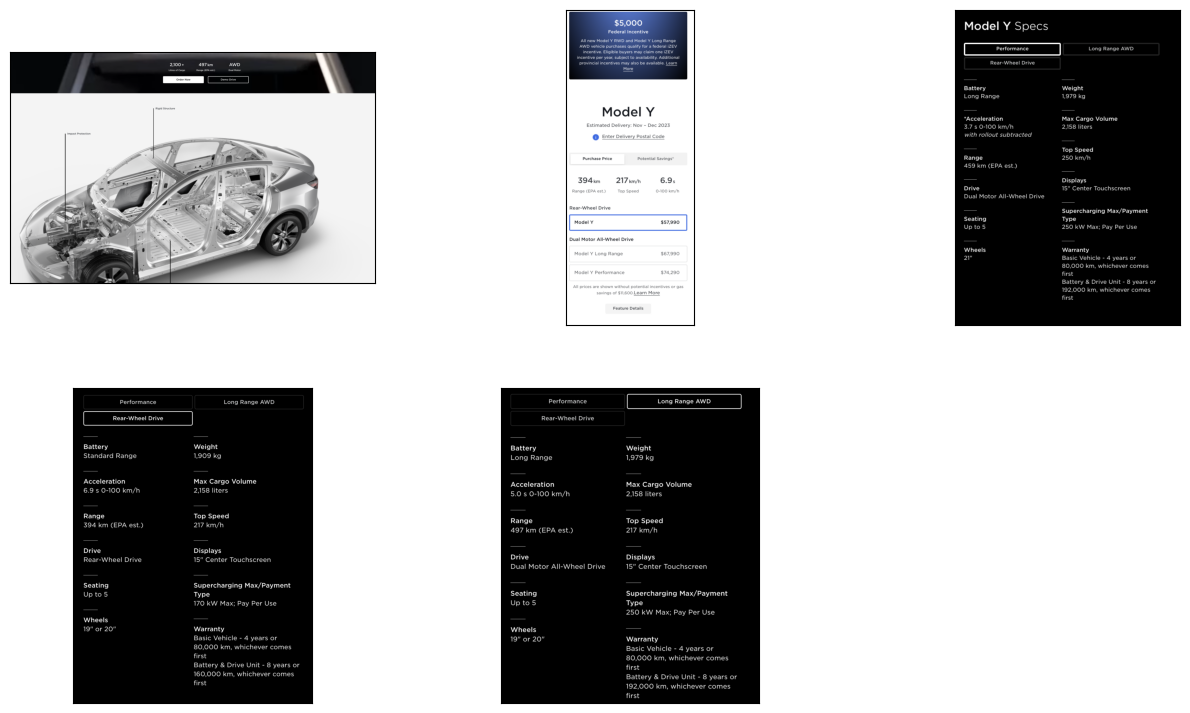

In [183]:
image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))
plot_images(image_paths)

In [184]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

image_documents = SimpleDirectoryReader("./input_images").load_data()

In [185]:
response = openai_mm_llm.complete(
    prompt = "Describe the images as an alternative text",
    image_documents=image_documents,
)
print(response)

1. **Image 1:**
   - Title: Performance, Rear-Wheel Drive, Long Range AWD
   - Battery: Long Range
   - Weight: 1,979 kg
   - Acceleration: 5.0 s 0-100 km/h
   - Max Cargo Volume: 2,158 liters
   - Range: 497 km (EPA est.)
   - Top Speed: 217 km/h
   - Drive: Dual Motor All-Wheel Drive
   - Displays: 15" Center Touchscreen
   - Seating: Up to 5
   - Supercharging Max/Payment Type: 250 kW Max; Pay Per Use
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first; Battery & Drive Unit - 8 years or 192,000 km, whichever comes first

2. **Image 2:**
   - A semi-transparent image of a car showing its internal structure. Labels point to "Impact Protection" and "Rigid Structure." The top section of the image includes options to "Order Now" and "Demo Drive," with specifications such as "2,100+ liters of Cargo," "497 km Range (EPA est.)," and "AWD Dual Motor."

3. **Image 3:**
   - Title: Model Y Specs
   - Performance, Rear-Wheel Drive, Long Range AWD


In [186]:
import requests

def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params = {
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][0]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [187]:
from pathlib import Path 
import requests 
import urllib.request 
import time

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 5

wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}

data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params = {
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]
    
    with open(data_path / f"{title}.txt", "w") as fp:
        fp. write(wiki_text)
        
    images_per_wiki = 0
    try:
        list_img_urls = get_wikipedia_images(title)
        
        for url in list_img_urls:
            if ( 
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                
                urllib.request.urlretrieve( 
                    url, data_path / f"{image_uuid}.jpg"
                )
                time.sleep(1)
                images_per_wiki += 1

                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except Exception as e:
        print(e)
        print("Number of images found for Wikipedia page: {} are {}". format(title, images_per_wiki))
        continue

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Number of images found for Wikipedia page: Audi e-tron are 0
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Number of images found for Wikipedia page: Rivian are 0
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Number of images found for Wikipedia page: Tesla Model 3 are 0
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Number of images found for Wikipedia page: Porsche Taycan are 0
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Number of images found for Wikipedia page: Tesla Model X are 0
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] 

In [167]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import StorageContext

client = qdrant_client.QdrantClient (path="qdrant_mm_db" )

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection")
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection")
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store)

In [170]:
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

In [171]:
documents[0]

Document(id_='ffddda82-a80a-4d84-bffb-56c0d79fb095', embedding=None, metadata={'file_path': '/Users/siddhiapraj/GenAIExperiments/LlamaIndex/mixed_wiki/Audi e-tron.txt', 'file_name': 'Audi e-tron.txt', 'file_type': 'text/plain', 'file_size': 13780, 'creation_date': '2024-08-14', 'last_modified_date': '2024-08-14'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='The Audi e-tron is a series of electric and hybrid cars shown by Audi from 2009 onwards. In 2012 Audi unveiled a plug-in hybrid version, the A3 Sportback e-tron, released to retail customers in Europe in August 2014, and slated for the U.S. in 2015. A decade after the unveiling of the first e-tron concept at the 2009 International Motor Show Germany, Audi\'s first fully electric e-tron SUV went in

In [173]:
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)